In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df['Gender'] = df['Gender'].fillna( df['Gender'].dropna().mode().values[0] )
df['Married'] = df['Married'].fillna( df['Married'].dropna().mode().values[0] )
df['Dependents'] = df['Dependents'].fillna( df['Dependents'].dropna().mode().values[0] )
df['Self_Employed'] = df['Self_Employed'].fillna( df['Self_Employed'].dropna().mode().values[0] )
df['LoanAmount'] = df['LoanAmount'].fillna( df['LoanAmount'].dropna().mean() )
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna( df['Loan_Amount_Term'].dropna().mode().values[0] )
df['Credit_History'] = df['Credit_History'].fillna( df['Credit_History'].dropna().mode().values[0] )
df['Dependents'] = df['Dependents'].str.rstrip('+')
df['Gender'] = df['Gender'].map({'Female':0,'Male':1}).astype(np.int)
df['Married'] = df['Married'].map({'No':0, 'Yes':1}).astype(np.int)
df['Education'] = df['Education'].map({'Not Graduate':0, 'Graduate':1}).astype(np.int)
df['Self_Employed'] = df['Self_Employed'].map({'No':0, 'Yes':1}).astype(np.int)
df['Loan_Status'] = df['Loan_Status'].map({'N':0, 'Y':1}).astype(np.int)
df['Dependents'] = df['Dependents'].astype(np.int)

In [4]:
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [5]:
dtrain= pd.get_dummies(df)

In [6]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV 
train = dtrain
target = 'Loan_Status'
IDcol = 'Loan_ID'

In [7]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Loan_Status'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Loan_Status'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Loan_Status'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')



Model Report
Accuracy : 0.9186
AUC Score (Train): 0.984918


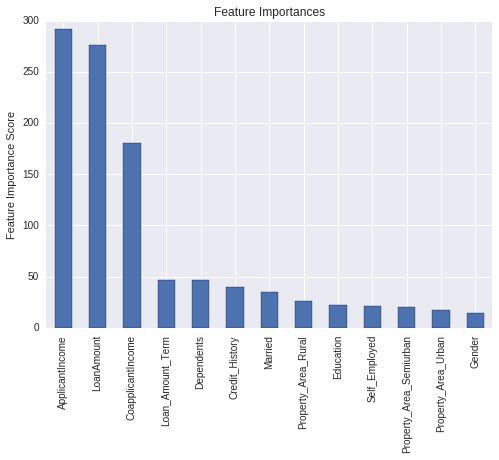

In [8]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8,
                     colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb1, train, predictors)

In [9]:
param_test1 = { 'max_depth':list(range(3,10,2)), 'min_child_weight':list(range(1,6,2))}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.74538, std: 0.04629, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.75191, std: 0.04508, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.75320, std: 0.03758, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.74620, std: 0.04597, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.75153, std: 0.04587, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.75271, std: 0.04045, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.75128, std: 0.04208, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.74546, std: 0.05205, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.75243, std: 0.04625, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.74995, std: 0.03917, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.74883, std: 0.04849, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.75656, std: 0.04573, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 9, 'min_child_weight': 5

In [10]:
param_test2 = { 'max_depth':[8,9,10], 'min_child_weight':[4,5,6] }
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.75185, std: 0.04845, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: 0.75578, std: 0.04642, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: 0.75804, std: 0.04415, params: {'max_depth': 8, 'min_child_weight': 6},
  mean: 0.75014, std: 0.04887, params: {'max_depth': 9, 'min_child_weight': 4},
  mean: 0.75656, std: 0.04573, params: {'max_depth': 9, 'min_child_weight': 5},
  mean: 0.75804, std: 0.04415, params: {'max_depth': 9, 'min_child_weight': 6},
  mean: 0.75115, std: 0.04894, params: {'max_depth': 10, 'min_child_weight': 4},
  mean: 0.75656, std: 0.04573, params: {'max_depth': 10, 'min_child_weight': 5},
  mean: 0.75804, std: 0.04415, params: {'max_depth': 10, 'min_child_weight': 6}],
 {'max_depth': 8, 'min_child_weight': 6},
 0.7580432415881333)

In [11]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=8,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=140, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [12]:
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

([mean: 0.75804, std: 0.04415, params: {'min_child_weight': 6},
  mean: 0.75407, std: 0.03464, params: {'min_child_weight': 8},
  mean: 0.75503, std: 0.03964, params: {'min_child_weight': 10},
  mean: 0.75517, std: 0.03951, params: {'min_child_weight': 12}],
 {'min_child_weight': 6},
 0.7580432415881333)

In [13]:
param_test2c = {
 'min_child_weight':[6,7]
}
gsearch2c = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=8,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2c.fit(train[predictors],train[target])
gsearch2c.grid_scores_, gsearch2c.best_params_, gsearch2c.best_score_

([mean: 0.75804, std: 0.04415, params: {'min_child_weight': 6},
  mean: 0.75407, std: 0.03464, params: {'min_child_weight': 8},
  mean: 0.75503, std: 0.03964, params: {'min_child_weight': 10},
  mean: 0.75517, std: 0.03951, params: {'min_child_weight': 12}],
 {'min_child_weight': 6},
 0.7580432415881333)

In [14]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=8,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.75804, std: 0.04415, params: {'gamma': 0.0},
  mean: 0.75831, std: 0.04431, params: {'gamma': 0.1},
  mean: 0.75667, std: 0.04149, params: {'gamma': 0.2},
  mean: 0.75260, std: 0.04321, params: {'gamma': 0.3},
  mean: 0.75780, std: 0.04605, params: {'gamma': 0.4}],
 {'gamma': 0.1},
 0.75831490490933218)


Model Report
Accuracy : 0.8143
AUC Score (Train): 0.914655


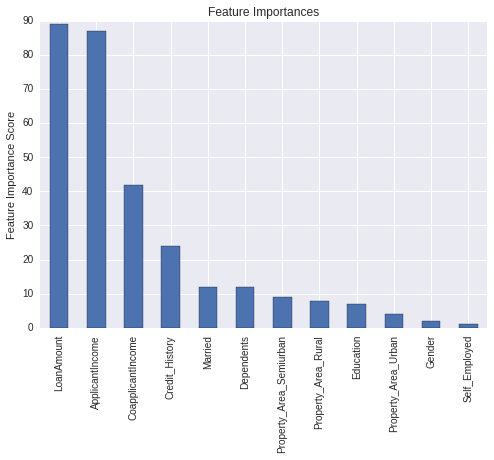

In [15]:
xgb2 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=8, min_child_weight=6, gamma=0.1, subsample=0.8,
                     colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb2, train, predictors)

In [16]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=8,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.74927, std: 0.04252, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.74761, std: 0.04192, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.74978, std: 0.04527, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.75374, std: 0.04096, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.75373, std: 0.03959, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.75229, std: 0.03935, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.75455, std: 0.04106, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.75439, std: 0.04098, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.75165, std: 0.04236, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.75167, std: 0.04022, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.75698, std: 0.04308, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.75781, std: 0.04062, params: {'subsample': 0.9, 'colsample_bytree'

In [17]:
param_test4a = {
 'subsample':[i/10.0 for i in range(9,12)],
 'colsample_bytree':[i/10.0 for i in range(9,12)]
}
gsearch4a = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=8,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.74927, std: 0.04252, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.74761, std: 0.04192, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.74978, std: 0.04527, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.75374, std: 0.04096, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.75373, std: 0.03959, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.75229, std: 0.03935, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.75455, std: 0.04106, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.75439, std: 0.04098, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.75165, std: 0.04236, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.75167, std: 0.04022, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.75698, std: 0.04308, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.75781, std: 0.04062, params: {'subsample': 0.9, 'colsample_bytree'

In [20]:
param_test5 = {
 'subsample':[i/100.0 for i in range(95,105,5)],
 'colsample_bytree':[i/100.0 for i in range(95,105,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=8,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=6, missing=None, n_estimators=177, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.95, 1.0], 'colsample_bytree': [0.95, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [21]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.76148, std: 0.04423, params: {'subsample': 0.95, 'colsample_bytree': 0.95},
  mean: 0.76646, std: 0.04266, params: {'subsample': 1.0, 'colsample_bytree': 0.95},
  mean: 0.76595, std: 0.03866, params: {'subsample': 0.95, 'colsample_bytree': 1.0},
  mean: 0.76371, std: 0.04567, params: {'subsample': 1.0, 'colsample_bytree': 1.0}],
 {'colsample_bytree': 0.95, 'subsample': 1.0},
 0.76646225291736125)

In [22]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=8,
 min_child_weight=6, gamma=0.1, subsample=0.95, colsample_bytree=0.95,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.76148, std: 0.04423, params: {'reg_alpha': 1e-05},
  mean: 0.75951, std: 0.04004, params: {'reg_alpha': 0.01},
  mean: 0.76291, std: 0.04174, params: {'reg_alpha': 0.1},
  mean: 0.76493, std: 0.03972, params: {'reg_alpha': 1},
  mean: 0.70554, std: 0.04776, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 0.76492827090350324)

In [23]:
param_test6a = {
 'reg_alpha':[1,2,3,4,5]
}
gsearch6a = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=8,
 min_child_weight=6, gamma=0.1, subsample=0.95, colsample_bytree=0.95,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6a, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6a.fit(train[predictors],train[target])
gsearch6a.grid_scores_, gsearch6a.best_params_, gsearch6a.best_score_

([mean: 0.76493, std: 0.03972, params: {'reg_alpha': 1},
  mean: 0.76584, std: 0.03727, params: {'reg_alpha': 2},
  mean: 0.76526, std: 0.03648, params: {'reg_alpha': 3},
  mean: 0.75944, std: 0.03965, params: {'reg_alpha': 4},
  mean: 0.75641, std: 0.03361, params: {'reg_alpha': 5}],
 {'reg_alpha': 2},
 0.76584266095102005)


Model Report
Accuracy : 0.8371
AUC Score (Train): 0.933390


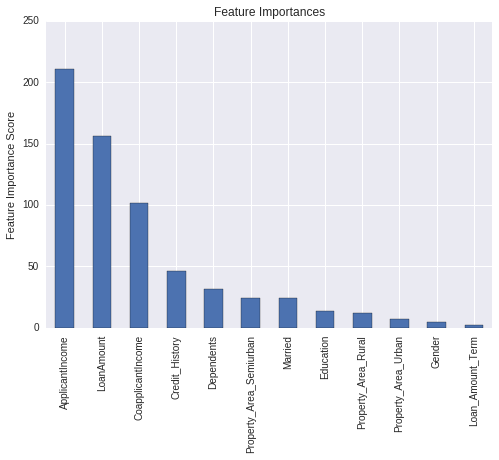

In [24]:
xgb3 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=8, min_child_weight=6, gamma=0.1, subsample=0.95,
                     colsample_bytree=0.95, reg_alpha=2, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb3, train, predictors)